In [1]:
import geopandas as gpd
import pandas as pd
from scipy.stats import pearsonr, spearmanr
from sklearn.feature_selection import mutual_info_regression
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import altair as alt
from mpl_toolkits.mplot3d import Axes3D
alt.data_transformers.enable("vegafusion")
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
import warnings
import sys
from importlib import reload

warnings.filterwarnings('ignore')

In [2]:
gpd.__version__

'1.0.1'

In [4]:
import momepy
momepy.__version__

'0.8.1'

In [2]:
sys.path.append("../../src")

In [3]:
import main
import vis

In [4]:
reload(vis)

<module 'vis' from '/Users/lisawink/Documents/freiburg/notebooks/visualisations/../../src/vis.py'>

In [5]:
temp = pd.read_csv('/Users/lisawink/Documents/paper1/data/raw_data/marvin_2024.csv')
temp['datetime']=pd.to_datetime(temp['datetime'])
temp['datetime_UTC'] = temp['datetime']
temp['value'] = temp['ta']
temp['datetime_UTC'] = temp['datetime_UTC'].astype(str)
temp = temp.pivot(index='station_id', columns='datetime_UTC', values='value')

In [6]:
hin =pd.read_csv('/Users/lisawink/Documents/paper1/data/processed_data/2_year_heat_island_dates_night.csv')

In [8]:
radius = 300
var = 'BuAre_sum'
time = hin.values.flatten()

In [10]:
def multiple_scales(vars):

    radii = [30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200,210,220,230,240,250,260,270,280,290,300,320,340,360,380,400,450,500,600,750,1000,1250,1500,1750,2000]
    mean_stats = {}
    std_stats = {}
    spearman_stats = {}
    p_value_stats = {}
    pearson_stats = {}
    rmse_stats = {}
    cooks_stats = {}
    mi_stats = {}
    
    for radius in radii:
        mean_stats[radius] = {}
        std_stats[radius] = {}
        spearman_stats[radius] = {}
        p_value_stats[radius] = {}
        pearson_stats[radius] = {}
        rmse_stats[radius] = {}
        cooks_stats[radius] = {}
        mi_stats[radius] = {}
        
        for var in vars:
            data, mean, std, spearman_corr, p_value, pearson_corr, r_squared, rmse, cooks_d, mi, y_pred = vis.stats_multiple_times(radius, var, time, temp)
            mean_stats[radius][var] = mean
            std_stats[radius][var] = std
            spearman_stats[radius][var] = spearman_corr
            p_value_stats[radius][var] = p_value
            pearson_stats[radius][var] = pearson_corr
            rmse_stats[radius][var] = rmse
            cooks_stats[radius][var] = cooks_d
            mi_stats[radius][var] = mi
            
    return mean_stats, std_stats, spearman_stats, p_value_stats, pearson_stats, rmse_stats, cooks_stats, mi_stats

In [11]:
params = ['BuAre_sum', 'BuVol_3D_sum', 'BuEWA_3D_sum', 'BuIBD', 'BuAdj', 'BuSWR_3D_median', 'BuHt_wmean','StrHW_median','SVF_3D_mean', 'BuERI_mode','StrClo400_median']

In [12]:
mean_stats, std_stats, spearman_stats, p_value_stats, pearson_stats, rmse_stats, cooks_stats, mi_stats = multiple_scales(params)

In [13]:
mean_stats = pd.DataFrame(mean_stats).T
std_stats = pd.DataFrame(std_stats).T
spearman_stats = pd.DataFrame(spearman_stats).T
p_value_stats = pd.DataFrame(p_value_stats).T
pearson_stats = pd.DataFrame(pearson_stats).T
rmse_stats = pd.DataFrame(rmse_stats).T
cooks_stats = pd.DataFrame(cooks_stats).T
mi_stats = pd.DataFrame(mi_stats).T

In [14]:
spearman_stats = spearman_stats.apply(lambda x: abs(x))

In [15]:
mean_stats = mean_stats.apply(lambda x: abs(x))

In [16]:
mean_stats['BuAre_sum'] = mean_stats['BuAre_sum'] / mean_stats.index**2*np.pi
std_stats['BuAre_sum'] = std_stats['BuAre_sum'] / std_stats.index**2*np.pi
mean_stats['BuEWA_3D_sum'] = mean_stats['BuEWA_3D_sum'] / (mean_stats.index**2*np.pi)
std_stats['BuEWA_3D_sum'] = std_stats['BuEWA_3D_sum'] / (std_stats.index**2*np.pi)
mean_stats["BuVol_3D_sum"] = mean_stats["BuVol_3D_sum"] / (mean_stats.index**2*np.pi)
std_stats["BuVol_3D_sum"] = std_stats["BuVol_3D_sum"] / (std_stats.index**2*np.pi)

In [17]:
# standardise columns ending in _mean between 0 and 1
def standardize_column(df, column_name):
    min_val = df[column_name].min()
    max_val = df[column_name].max()
    df[column_name] = (df[column_name] - min_val) / (max_val - min_val)
    return df

In [18]:
for col in mean_stats.columns:
    mean_stats = standardize_column(mean_stats, col)

In [19]:
for col in std_stats.columns:
    std_stats = standardize_column(std_stats, col)

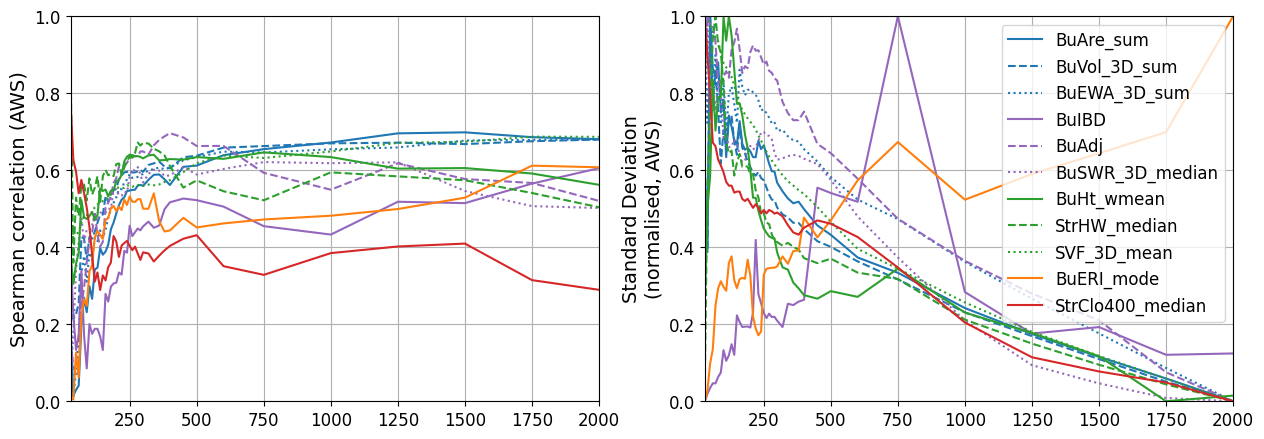

In [22]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))

linestyle_mapping = {
    'BuAre_sum': '-',
    'BuVol_3D_sum': '--',
    'BuEWA_3D_sum': ':',
    'BuIBD':'-',
    'BuAdj':'--',
    'BuSWR_3D_median':':',
    'BuHt_wmean': '-',
    'StrHW_median': '--',
    'SVF_3D_mean': ':',
    'BuERI_mode': '-',
    'StrClo400_median': '-'
}

color_mapping = {
    'BuAre_sum': 'tab:blue',
    'BuVol_3D_sum': 'tab:blue',
    'BuEWA_3D_sum': 'tab:blue',
    'BuIBD':'tab:purple',
    'BuAdj':'tab:purple',
    'BuSWR_3D_median':'tab:purple',
    'BuHt_wmean': 'tab:green',
    'SVF_3D_mean': 'tab:green',
    'StrHW_median': 'tab:green',
    'BuERI_mode': 'tab:orange',
    'StrClo400_median': 'tab:red'
}

for param in params:
    axs[0].plot(spearman_stats[param], label=param, linestyle=linestyle_mapping[param], color=color_mapping[param])
axs[0].set_ylabel('Spearman correlation (AWS)', fontsize=14)
axs[0].set_ylim(0, 1)
axs[0].set_xlim(30, 2000)
#axs[0, 0].set_xticklabels([])
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].grid()

for param in params:
    axs[1].plot(std_stats[param], label=param, linestyle=linestyle_mapping[param], color=color_mapping[param])
axs[1].set_ylabel("Standard Deviation\n(normalised, AWS)", fontsize=14)
axs[1].legend(prop={'size': 12})
axs[1].set_ylim(0, 1)
axs[1].set_xlim(30, 2000)
#axs[0, 1].set_xticklabels([])
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[1].grid()

plt.savefig('/Users/lisawink/Documents/paper1/figures/fig9/aws_2_year.png', dpi=300, bbox_inches='tight')
plt.savefig('/Users/lisawink/Documents/paper1/figures/fig9/aws_2_year.svg', dpi=300, bbox_inches='tight')

In [37]:
# combine mean_stats, std_stats, spearman_stats, p_value_stats, pearson_stats, rmse_stats, cooks_stats, mi_stats into one dataframe and add name to end of each column
combined_stats = pd.DataFrame()

for dtf, name in zip([mean_stats, std_stats, spearman_stats, p_value_stats, pearson_stats, rmse_stats, cooks_stats, mi_stats],
                    ['mean', 'std', 'spearman', 'p_value', 'pearson', 'rmse', 'cooks', 'mi']):
    df_renamed = dtf.add_suffix(f'_{name}')
    combined_stats = pd.concat([combined_stats, df_renamed], axis=1)

In [39]:
# for every p value greater than  0.05, make spearman correlation value nan in each row of the df
for i in params:
    # If the p-value column is greater than 0.05, set the correlation column to NaN
    combined_stats.loc[combined_stats[i+'_p_value'] > 0.05, i+'_spearman'] = np.nan

In [42]:
df = pd.read_csv('/Users/lisawink/Documents/paper1/data/processed_data/mbike/270623_stats_scales.csv', index_col=0)

In [43]:
df['BuAre_sum_mean'] = df['BuAre_sum_mean'] / df.index**2*np.pi
df['BuAre_sum_std'] = df['BuAre_sum_std'] / df.index**2*np.pi
df['BuEWA_3D_sum_mean'] = df['BuEWA_3D_sum_mean'] / (df.index**2*np.pi)
df['BuEWA_3D_sum_std'] = df['BuEWA_3D_sum_std'] / (df.index**2*np.pi)
df["BuVol_3D_sum_mean"] = df["BuVol_3D_sum_mean"] / (df.index**2*np.pi)
df["BuVol_3D_sum_std"] = df["BuVol_3D_sum_std"] / (df.index**2*np.pi)

In [44]:
# standardise columns ending in _mean between 0 and 1
def standardize_column(df, column_name):
    min_val = df[column_name].min()
    max_val = df[column_name].max()
    df[column_name] = (df[column_name] - min_val) / (max_val - min_val)
    return df

for col in df.columns:
    if col.endswith('_mean'):
        df = standardize_column(df, col)
    if col.endswith('_std'):
        df = standardize_column(df, col)

In [45]:
# for every p value greater than  0.05, make spearman correlation value nan in each row of the df

for i in params:
    # If the p-value column is greater than 0.05, set the correlation column to NaN
    df.loc[df[i + '_spearman_p_value'] > 0.05, i + '_spearman_corr'] = np.nan

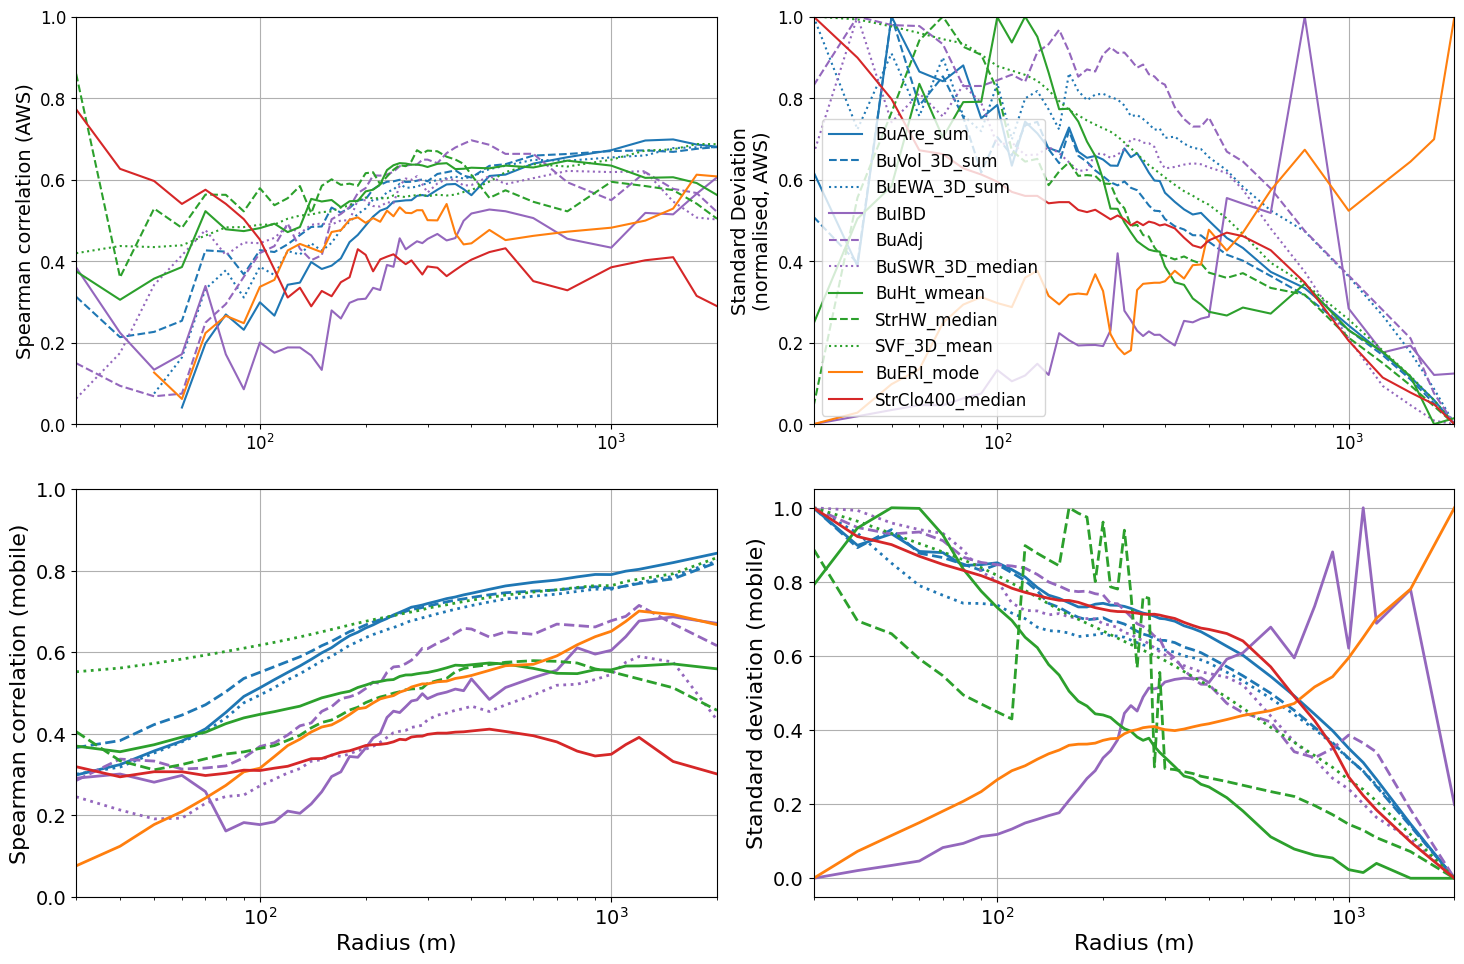

In [46]:
fig, axs = plt.subplots(2,2, figsize=(15,10))

linestyle_mapping = {
    'BuAre_sum': '-',
    'BuVol_3D_sum': '--',
    'BuEWA_3D_sum': ':',
    'BuIBD':'-',
    'BuAdj':'--',
    'BuSWR_3D_median':':',
    'BuHt_wmean': '-',
    'StrHW_median': '--',
    'SVF_3D_mean': ':',
    'BuERI_mode': '-',
    'StrClo400_median': '-'
}

color_mapping = {
    'BuAre_sum': 'tab:blue',
    'BuVol_3D_sum': 'tab:blue',
    'BuEWA_3D_sum': 'tab:blue',
    'BuIBD':'tab:purple',
    'BuAdj':'tab:purple',
    'BuSWR_3D_median':'tab:purple',
    'BuHt_wmean': 'tab:green',
    'StrHW_median': 'tab:green',
    'SVF_3D_mean': 'tab:green',
    'BuERI_mode': 'tab:orange',
    'StrClo400_median': 'tab:red'
}

axs[0,0].set_xscale('log')
for param in params:
    axs[0,0].plot(combined_stats[param+'_spearman'], label=param, linestyle=linestyle_mapping[param], color=color_mapping[param])
axs[0,0].set_ylabel('Spearman correlation (AWS)', fontsize=14)
axs[0,0].set_ylim(0, 1)
axs[0,0].set_xlim(30, 2000)
#axs[0, 0].set_xticklabels([])
axs[0,0].tick_params(axis='both', which='major', labelsize=12)
axs[0,0].grid()

axs[0,1].set_xscale('log')
for param in params:
    axs[0,1].plot(combined_stats[param+'_std'], label=param, linestyle=linestyle_mapping[param], color=color_mapping[param])
axs[0,1].set_ylabel("Standard Deviation\n(normalised, AWS)", fontsize=14)
axs[0,1].legend(prop={'size': 12})
axs[0,1].set_ylim(0, 1)
axs[0,1].set_xlim(30, 2000)
#axs[0, 1].set_xticklabels([])
axs[0,1].tick_params(axis='both', which='major', labelsize=12)
axs[0,1].grid()

axs[1,0].set_xscale('log')
for param in params:
    axs[1,0].plot(abs(df[param+'_spearman_corr']), label=param, linestyle=linestyle_mapping[param], linewidth=2, color=color_mapping[param])
axs[1,0].set_ylabel('Spearman correlation (mobile)', fontsize=16)
axs[1,0].set_ylim(0, 1)
axs[1,0].set_xlim(30, 2000)
#axs[0, 0].set_xticklabels([])
axs[1,0].tick_params(axis='both', which='major', labelsize=14)
axs[1,0].grid()
axs[1,0].set_xlabel('Radius (m)', fontsize=16)

axs[1,1].set_xscale('log')
for param in params:
    axs[1,1].plot(df[param+'_std'], label=param, linestyle=linestyle_mapping[param],linewidth=2, color=color_mapping[param])
axs[1,1].set_ylabel('Standard deviation (mobile)', fontsize=16)
axs[1,1].grid()
#axs[1, 1].set_ylim(0.5, 1.1)
axs[1,1].set_xlim(30, 2000)
#axs[1, 1].set_xticklabels([])
axs[1,1].tick_params(axis='both', which='major', labelsize=14)
axs[1,1].set_xlabel('Radius (m)', fontsize=16)
#axs[1,1].legend(prop={'size': 14}, bbox_to_anchor=(1.05, 0.85), loc='upper left')


plt.tight_layout(pad = 2, w_pad=1)
plt.savefig('/Users/lisawink/Documents/paper1/figures/fig9/comb.png')
plt.savefig('/Users/lisawink/Documents/paper1/figures/fig9/comb.pdf')
plt.show()

In [75]:
import matplotlib.ticker

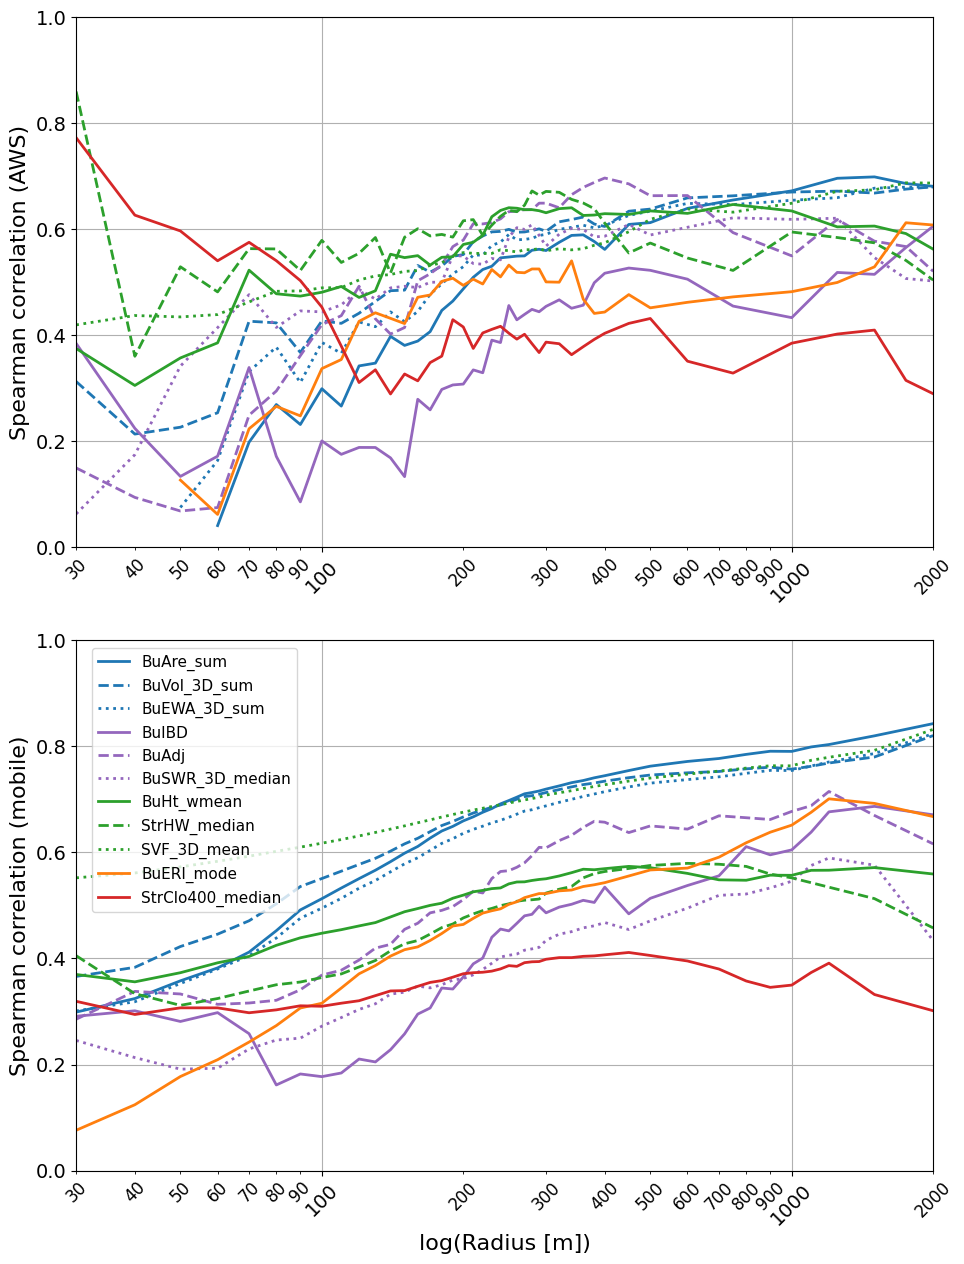

In [114]:
fig, axs = plt.subplots(2,1, figsize=(10,13))

linestyle_mapping = {
    'BuAre_sum': '-',
    'BuVol_3D_sum': '--',
    'BuEWA_3D_sum': ':',
    'BuIBD':'-',
    'BuAdj':'--',
    'BuSWR_3D_median':':',
    'BuHt_wmean': '-',
    'StrHW_median': '--',
    'SVF_3D_mean': ':',
    'BuERI_mode': '-',
    'StrClo400_median': '-'
}

color_mapping = {
    'BuAre_sum': 'tab:blue',
    'BuVol_3D_sum': 'tab:blue',
    'BuEWA_3D_sum': 'tab:blue',
    'BuIBD':'tab:purple',
    'BuAdj':'tab:purple',
    'BuSWR_3D_median':'tab:purple',
    'BuHt_wmean': 'tab:green',
    'StrHW_median': 'tab:green',
    'SVF_3D_mean': 'tab:green',
    'BuERI_mode': 'tab:orange',
    'StrClo400_median': 'tab:red'
}

axs[0].set_xscale('log')
for param in params:
    axs[0].plot(combined_stats[param+'_spearman'], label=param, linestyle=linestyle_mapping[param], linewidth=2, color=color_mapping[param])
axs[0].set_ylabel('Spearman correlation (AWS)', fontsize=16)
axs[0].set_ylim(0, 1)
axs[0].set_xlim(30, 2000)
#axs[0, 0].set_xticklabels([])
axs[0].tick_params(axis='both', which='major', labelsize=14)
axs[0].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[0].get_xaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
axs[0].grid()
axs[0].tick_params(axis='x', which='minor', rotation=45,labelsize=12)
axs[0].tick_params(axis='x', labelrotation=45)


axs[1].set_xscale('log')
for param in params:
    axs[1].plot(abs(df[param+'_spearman_corr']), label=param, linestyle=linestyle_mapping[param], linewidth=2, color=color_mapping[param])
axs[1].set_ylabel('Spearman correlation (mobile)', fontsize=16)
axs[1].set_ylim(0, 1)
axs[1].set_xlim(30, 2000)

axs[1].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
axs[1].get_xaxis().set_minor_formatter(matplotlib.ticker.ScalarFormatter())
axs[1].tick_params(axis='both', which='major', labelsize=14)
axs[1].grid()
axs[1].set_xlabel('log(Radius [m])', fontsize=16)
axs[1].tick_params(axis='x', labelrotation=45)
axs[1].tick_params(axis='x', which='minor', rotation=45,labelsize=12)
axs[1].legend(prop={'size': 11}, bbox_to_anchor=(0.01, 1), loc='upper left')



plt.tight_layout(pad = 2, w_pad=1)
plt.savefig('/Users/lisawink/Documents/paper1/figures/fig9/spear.png')
plt.savefig('/Users/lisawink/Documents/paper1/figures/fig9/spear.pdf')
plt.show()

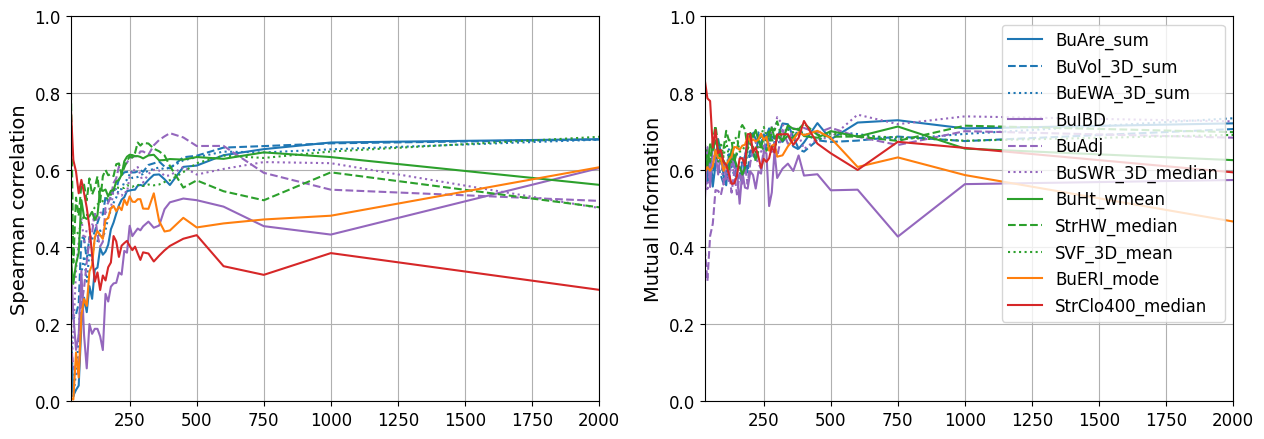

In [112]:
fig, axs = plt.subplots(1,2, figsize=(15, 5))

for param in params:
    axs[0].plot(spearman_stats[param], label=param, linestyle=linestyle_mapping[param], color=color_mapping[param])
axs[0].set_ylabel('Spearman correlation', fontsize=14)
axs[0].set_ylim(0, 1)
axs[0].set_xlim(30, 2000)
#axs[0, 0].set_xticklabels([])
axs[0].tick_params(axis='both', which='major', labelsize=12)
axs[0].grid()

for param in params:
    axs[1].plot(mi_stats[param], label=param, linestyle=linestyle_mapping[param], color=color_mapping[param])
axs[1].set_ylabel("Mutual Information", fontsize=14)
axs[1].legend(prop={'size': 12})
axs[1].set_ylim(0, 1)
axs[1].set_xlim(30, 2000)
#axs[0, 1].set_xticklabels([])
axs[1].tick_params(axis='both', which='major', labelsize=12)
axs[1].grid()

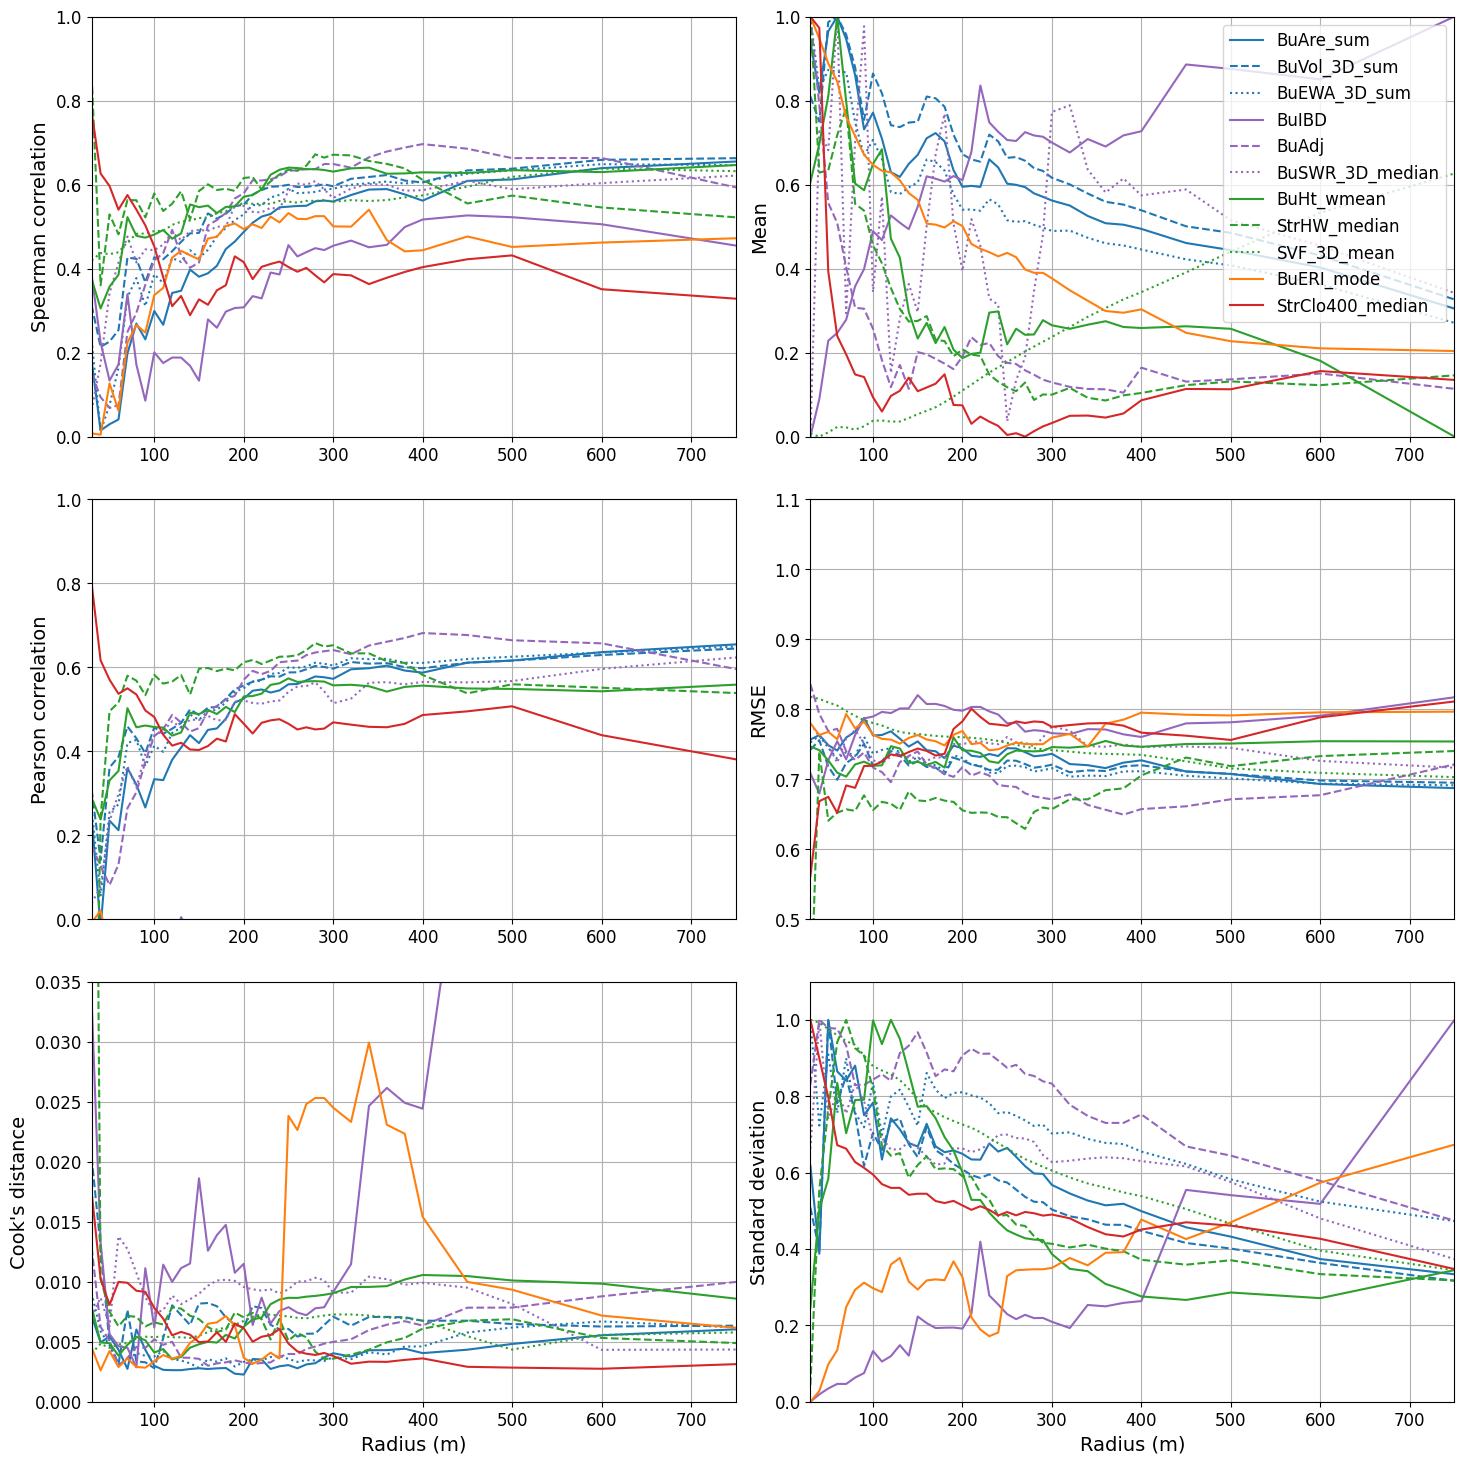

In [111]:
# make 4 subplots
fig, axs = plt.subplots(3,2, figsize=(15, 15))

linestyle_mapping = {
    'BuAre_sum': '-',
    'BuVol_3D_sum': '--',
    'BuEWA_3D_sum': ':',
    'BuIBD':'-',
    'BuAdj':'--',
    'BuSWR_3D_median':':',
    'BuHt_wmean': '-',
    'StrHW_median': '--',
    'SVF_3D_mean': ':',
    'BuERI_mode': '-',
    'StrClo400_median': '-'
}

color_mapping = {
    'BuAre_sum': 'tab:blue',
    'BuVol_3D_sum': 'tab:blue',
    'BuEWA_3D_sum': 'tab:blue',
    'BuIBD':'tab:purple',
    'BuAdj':'tab:purple',
    'BuSWR_3D_median':'tab:purple',
    'BuHt_wmean': 'tab:green',
    'SVF_3D_mean': 'tab:green',
    'StrHW_median': 'tab:green',
    'BuERI_mode': 'tab:orange',
    'StrClo400_median': 'tab:red'
}

for param in params:
    axs[0, 0].plot(spearman_stats[param], label=param, linestyle=linestyle_mapping[param], color=color_mapping[param])
axs[0, 0].set_ylabel('Spearman correlation', fontsize=14)
axs[0, 0].set_ylim(0, 1)
axs[0, 0].set_xlim(30, 750)
#axs[0, 0].set_xticklabels([])
axs[0, 0].tick_params(axis='both', which='major', labelsize=12)
axs[0, 0].grid()

for param in params:
    axs[0, 1].plot(mean_stats[param], label=param, linestyle=linestyle_mapping[param], color=color_mapping[param])
axs[0, 1].set_ylabel("Mean", fontsize=14)
axs[0, 1].legend(prop={'size': 12})
axs[0, 1].set_ylim(0, 1)
axs[0, 1].set_xlim(30, 750)
#axs[0, 1].set_xticklabels([])
axs[0, 1].tick_params(axis='both', which='major', labelsize=12)
axs[0, 1].grid()

for param in params:
    axs[1, 0].plot(pearson_stats[param], label=param, linestyle=linestyle_mapping[param], color=color_mapping[param])
axs[1, 0].set_ylabel('Pearson correlation', fontsize=14)
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_xlim(30, 750)
#axs[1, 0].set_xticklabels([])
axs[1, 0].tick_params(axis='both', which='major', labelsize=12)
axs[1, 0].grid()

for param in params:
    axs[1, 1].plot(rmse_stats[param], label=param, linestyle=linestyle_mapping[param], color=color_mapping[param])
axs[1, 1].set_ylabel('RMSE', fontsize=14)
axs[1, 1].grid()
axs[1, 1].set_ylim(0.5, 1.1)
axs[1, 1].set_xlim(30, 750)
#axs[1, 1].set_xticklabels([])
axs[1, 1].tick_params(axis='both', which='major', labelsize=12)

for param in params:
    axs[2, 0].plot(cooks_stats[param], label=param, linestyle=linestyle_mapping[param], color=color_mapping[param])
axs[2, 0].set_ylabel("Cook's distance", fontsize=14)
axs[2, 0].set_ylim(0, 0.035)
axs[2, 0].set_xlim(30, 750)
axs[2, 0].set_xlabel('Radius (m)', fontsize=14)
axs[2, 0].tick_params(axis='both', which='major', labelsize=12)
axs[2, 0].grid()

for param in params:
    axs[2, 1].plot(std_stats[param], label=param, linestyle=linestyle_mapping[param], color=color_mapping[param])
axs[2, 1].set_ylabel("Standard deviation", fontsize=14)
axs[2, 1].set_ylim(0, 1.1)
axs[2, 1].set_xlim(30, 750)
axs[2, 1].set_xlabel('Radius (m)', fontsize=14)
axs[2, 1].tick_params(axis='both', which='major', labelsize=12)
axs[2, 1].grid()

plt.tight_layout(pad = 2, w_pad=1)
plt.savefig('/Users/lisawink/Documents/paper1/figures/fig9/2_year_param_scale_plot_featured_list.png')
plt.show()

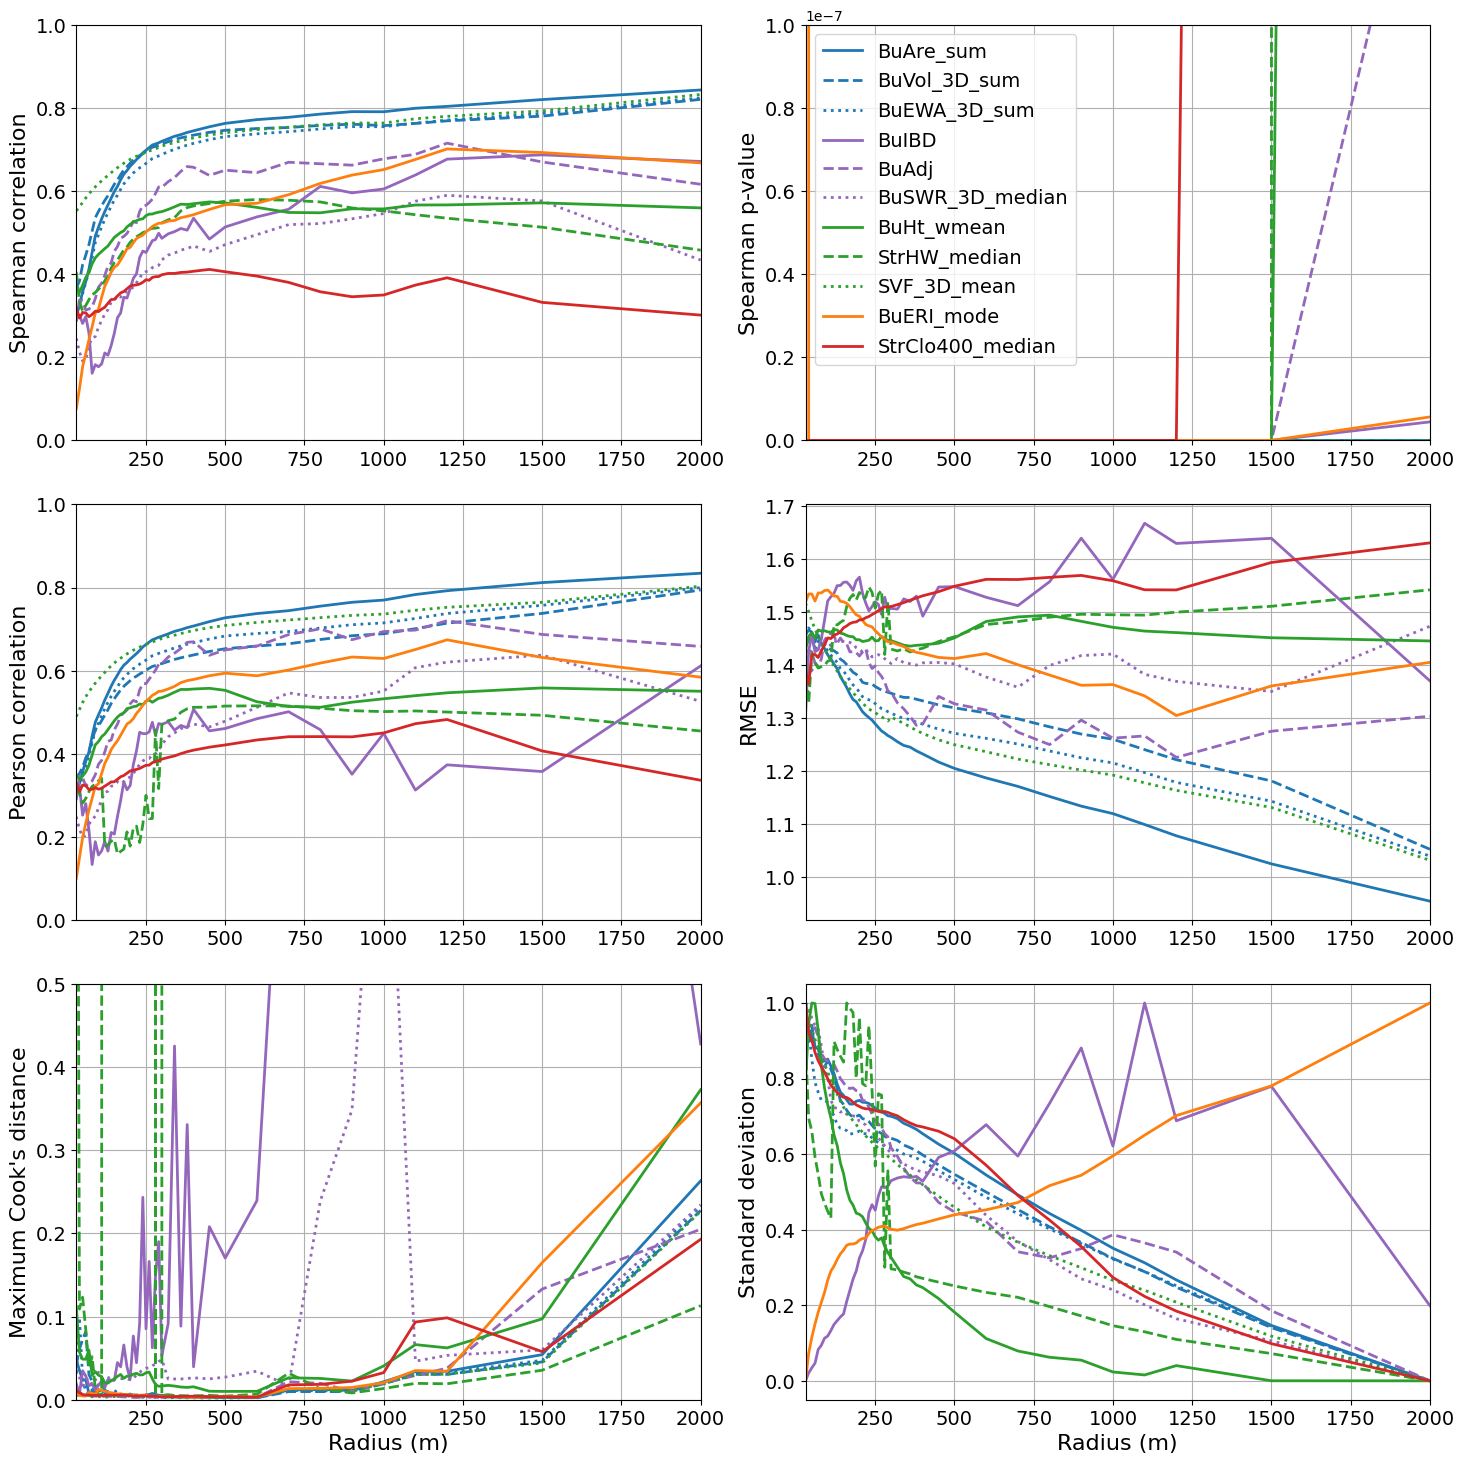

In [112]:
fig, axs = plt.subplots(3,2, figsize=(15, 15))


for var in params:
    axs[0, 0].plot(abs(df[var+'_spearman_corr']), label=var, linestyle=linestyle_mapping[var], linewidth=2, color=color_mapping[var])
axs[0, 0].set_ylabel('Spearman correlation', fontsize=16)
axs[0, 0].set_ylim(0, 1)
axs[0, 0].set_xlim(30, 2000)
#axs[0, 0].set_xticklabels([])
axs[0, 0].tick_params(axis='both', which='major', labelsize=14)
axs[0, 0].grid()

for var in params:
    axs[0, 1].plot(df[var+'_spearman_p_value'], label=var, linestyle=linestyle_mapping[var], linewidth=2, color=color_mapping[var])
axs[0, 1].set_ylabel("Spearman p-value", fontsize=16)
axs[0, 1].legend(prop={'size': 14})
axs[0, 1].set_ylim(0, 0.0000001)
axs[0, 1].set_xlim(30, 2000)
#axs[0, 1].set_xticklabels([])
axs[0, 1].tick_params(axis='both', which='major', labelsize=14)
axs[0, 1].grid()

for var in params:
    axs[1, 0].plot(abs(df[var+'_pearson_corr']), label=var, linestyle=linestyle_mapping[var], linewidth=2,color=color_mapping[var])
axs[1, 0].set_ylabel('Pearson correlation', fontsize=16)
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_xlim(30, 2000)
#axs[1, 0].set_xticklabels([])
axs[1, 0].tick_params(axis='both', which='major', labelsize=14)
axs[1, 0].grid()

for var in params:
    axs[1, 1].plot(df[var+'_rmse'], label=var, linestyle=linestyle_mapping[var],linewidth=2, color=color_mapping[var])
axs[1, 1].set_ylabel('RMSE', fontsize=16)
axs[1, 1].grid()
#axs[1, 1].set_ylim(0.5, 1.1)
axs[1, 1].set_xlim(30, 2000)
#axs[1, 1].set_xticklabels([])
axs[1, 1].tick_params(axis='both', which='major', labelsize=14)

for var in params:
    axs[2, 0].plot(df[var+'_cooks_d'], label=var, linestyle=linestyle_mapping[var],linewidth=2, color=color_mapping[var])
axs[2, 0].set_ylabel("Maximum Cook's distance", fontsize=16)
axs[2, 0].set_ylim(0, 0.5)
axs[2, 0].set_xlim(30, 2000)
axs[2, 0].set_xlabel('Radius (m)', fontsize=16)
axs[2, 0].tick_params(axis='both', which='major', labelsize=14)
axs[2, 0].grid()

for var in params:
    axs[2, 1].plot(df[var+'_std'], label=var, linestyle=linestyle_mapping[var],linewidth=2, color=color_mapping[var])
axs[2, 1].set_ylabel("Standard deviation", fontsize=16)
#axs[2, 1].set_ylim(0, 2)
axs[2, 1].set_xlim(30, 2000)
axs[2, 1].set_xlabel('Radius (m)', fontsize=16)
axs[2, 1].tick_params(axis='both', which='major', labelsize=14)
axs[2, 1].grid()

plt.tight_layout(pad = 2, w_pad=1)
plt.savefig('/Users/lisawink/Documents/paper1/figures/fig9/mbike270623_param_scale_plot_featured_list.png')
plt.savefig('/Users/lisawink/Documents/paper1/figures/fig9/mbike270623_param_scale_plot_featured_list.pdf')
plt.show()

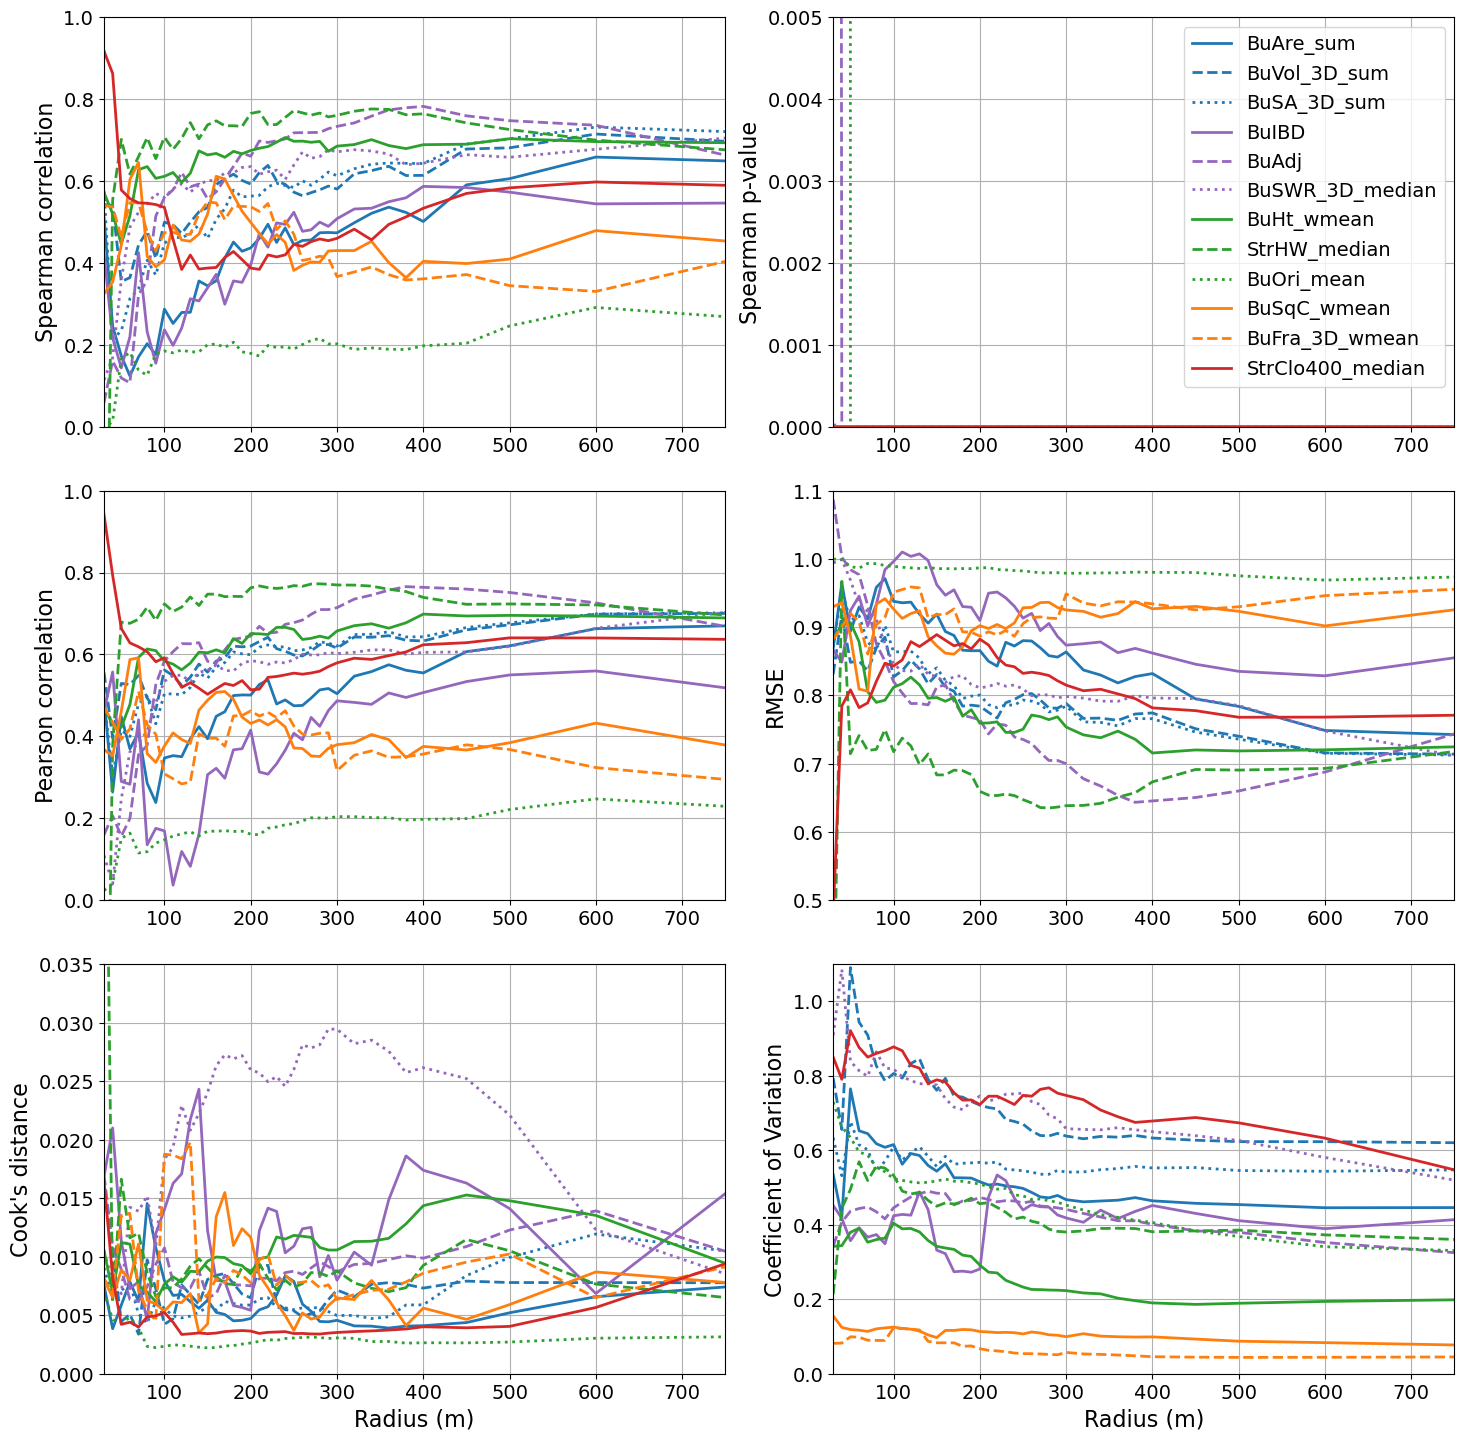

In [33]:
# make 4 subplots
fig, axs = plt.subplots(3,2, figsize=(15, 15))

linestyle_mapping = {
    'BuAre_sum': '-',
    'BuVol_3D_sum': '--',
    'BuSA_3D_sum': ':',
    'BuIBD':'-',
    'BuAdj':'--',
    'BuSWR_3D_median':':',
    'BuHt_wmean': '-',
    'StrHW_median': '--',
    'BuOri_mean': ':',
    'BuSqC_wmean': '-',
    'BuFra_3D_wmean': '--',
    'StrClo400_median': '-'
}

color_mapping = {
    'BuAre_sum': 'tab:blue',
    'BuVol_3D_sum': 'tab:blue',
    'BuSA_3D_sum': 'tab:blue',
    'BuIBD':'tab:purple',
    'BuAdj':'tab:purple',
    'BuSWR_3D_median':'tab:purple',
    'BuHt_wmean': 'tab:green',
    'StrHW_median': 'tab:green',
    'BuOri_mean': 'tab:green',
    'BuSqC_wmean': 'tab:orange',
    'BuFra_3D_wmean': 'tab:orange',
    'StrClo400_median': 'tab:red'
}

for param in params:
    axs[0, 0].plot(spearman_stats[param], label=param, linestyle=linestyle_mapping[param], linewidth=2, color=color_mapping[param])
axs[0, 0].set_ylabel('Spearman correlation', fontsize=16)
axs[0, 0].set_ylim(0, 1)
axs[0, 0].set_xlim(30, 750)
#axs[0, 0].set_xticklabels([])
axs[0, 0].tick_params(axis='both', which='major', labelsize=14)
axs[0, 0].grid()

for param in params:
    axs[0, 1].plot(p_value_stats[param], label=param, linestyle=linestyle_mapping[param],linewidth=2, color=color_mapping[param])
axs[0, 1].set_ylabel("Spearman p-value", fontsize=16)
axs[0, 1].legend(prop={'size': 14})
axs[0, 1].set_ylim(0, 0.005)
axs[0, 1].set_xlim(30, 750)
#axs[0, 1].set_xticklabels([])
axs[0, 1].tick_params(axis='both', which='major', labelsize=14)
axs[0, 1].grid()

for param in params:
    axs[1, 0].plot(pearson_stats[param], label=param, linestyle=linestyle_mapping[param], linewidth=2,color=color_mapping[param])
axs[1, 0].set_ylabel('Pearson correlation', fontsize=16)
axs[1, 0].set_ylim(0, 1)
axs[1, 0].set_xlim(30, 750)
#axs[1, 0].set_xticklabels([])
axs[1, 0].tick_params(axis='both', which='major', labelsize=14)
axs[1, 0].grid()

for param in params:
    axs[1, 1].plot(rmse_stats[param], label=param, linestyle=linestyle_mapping[param],linewidth=2, color=color_mapping[param])
axs[1, 1].set_ylabel('RMSE', fontsize=16)
axs[1, 1].grid()
axs[1, 1].set_ylim(0.5, 1.1)
axs[1, 1].set_xlim(30, 750)
#axs[1, 1].set_xticklabels([])
axs[1, 1].tick_params(axis='both', which='major', labelsize=14)

for param in params:
    axs[2, 0].plot(cooks_stats[param], label=param, linestyle=linestyle_mapping[param],linewidth=2, color=color_mapping[param])
axs[2, 0].set_ylabel("Cook's distance", fontsize=16)
axs[2, 0].set_ylim(0, 0.035)
axs[2, 0].set_xlim(30, 750)
axs[2, 0].set_xlabel('Radius (m)', fontsize=16)
axs[2, 0].tick_params(axis='both', which='major', labelsize=14)
axs[2, 0].grid()

for param in params:
    axs[2, 1].plot(mean_stats[param]/std_stats[param], label=param, linestyle=linestyle_mapping[param],linewidth=2, color=color_mapping[param])
axs[2, 1].set_ylabel("Coefficient of Variation", fontsize=16)
axs[2, 1].set_ylim(0, 1.1)
axs[2, 1].set_xlim(30, 750)
axs[2, 1].set_xlabel('Radius (m)', fontsize=16)
axs[2, 1].tick_params(axis='both', which='major', labelsize=14)
axs[2, 1].grid()

plt.tight_layout(pad = 2, w_pad=1)
plt.savefig('/Users/lisawink/Documents/paper1/figures/param_scale_plot_featured_list.png')
plt.savefig('/Users/lisawink/Documents/paper1/figures/param_scale_plot_featured_list.pdf')
plt.show()

In [58]:
p_value_stats

,BuAre_sum,BuVol_3D_sum,BuSA_3D_sum,BuIBD,BuAdj,BuSWR_3D_median,BuHt_wmean,StrHW_median,BuOri_mean,BuSqC_wmean,BuFra_3D_wmean,StrClo400_median
30,2.729171e-91,7.575096e-105,1.197163e-120,3.878971e-16,1.017898e-01,2.369748e-05,9.808053e-119,1.876839e-52,7.649720e-01,1.003967e-34,7.129802e-104,6.415671e-103
40,1.108180e-24,2.962466e-129,4.547925e-19,3.199217e-13,2.887973e-10,3.077056e-12,3.468698e-118,8.889902e-56,5.569148e-01,5.064233e-51,2.222582e-127,3.685033e-152
50,1.444222e-14,7.093988e-59,1.203955e-25,7.355939e-09,2.567405e-07,3.792755e-60,4.026280e-96,7.704978e-177,1.760987e-13,1.735231e-94,2.096673e-104,2.099962e-99
60,1.085766e-08,1.588629e-67,2.263448e-49,7.296669e-22,2.150682e-06,5.004889e-127,3.929062e-144,5.318243e-152,3.600714e-17,5.407209e-211,4.300320e-166,2.494310e-125
70,2.040356e-16,3.115070e-111,7.529776e-62,5.992598e-94,1.963455e-54,5.721730e-162,2.703981e-251,1.560321e-212,3.060565e-11,2.240954e-270,1.026780e-178,2.306047e-126
80,3.150866e-24,1.069383e-140,9.197182e-99,2.942923e-28,3.613483e-70,3.109796e-189,2.239049e-278,4.414962e-307,4.410729e-10,1.236413e-103,4.131596e-139,2.019383e-145
90,4.025506e-19,2.223516e-104,1.726870e-83,1.129251e-14,4.306561e-172,5.872807e-219,8.435262e-256,5.331963e-260,1.779305e-19,1.683229e-93,8.145148e-115,2.582009e-156
100,4.104547e-51,4.041637e-166,4.772007e-130,9.461996e-34,1.263147e-209,1.190693e-216,1.060016e-269,0.000000e+00,1.206046e-21,7.291800e-106,2.429143e-147,8.422282e-158
120,3.084993e-48,5.478048e-146,2.461852e-138,5.896954e-35,1.342785e-271,9.112855e-250,1.349364e-253,0.000000e+00,3.389007e-22,2.936919e-135,1.700379e-143,2.512121e-84
140,2.137210e-79,3.752828e-186,5.623166e-161,9.717475e-57,1.615144e-241,3.778620e-247,0.000000e+00,0.000000e+00,3.315711e-21,4.587834e-145,4.358714e-182,7.870974e-85


In [36]:
def plot_scales(vars):

    spearman_stats, p_value_stats, pearson_stats, rmse_stats, cooks_stats = multiple_scales(vars)

    spearman_stats = pd.DataFrame(spearman_stats).T
    p_value_stats = pd.DataFrame(p_value_stats).T
    pearson_stats = pd.DataFrame(pearson_stats).T
    rmse_stats = pd.DataFrame(rmse_stats).T
    cooks_stats = pd.DataFrame(cooks_stats).T

    # make 4 subplots
    fig, axs = plt.subplots(2,2, figsize=(10, 15))

    axs[0, 0].plot(spearman_stats)
    axs[0, 0].set_title('Spearman correlation')
    axs[0, 0].legend(vars)

    axs[0, 1].plot(pearson_stats)
    axs[0, 1].set_title('Pearson correlation')
    axs[0, 1].legend(vars)

    axs[1, 0].plot(rmse_stats)
    axs[1, 0].set_title('RMSE')
    axs[1, 0].legend(vars)

    axs[1, 1].plot(cooks_stats)
    axs[1, 1].set_title("Cook's distance")
    axs[1, 1].legend(vars)

    plt.show()

In [18]:
import warnings

warnings.filterwarnings('ignore')

In [21]:
param_scale_plot('BuAre_sum')

In [22]:
param_scale_plot('BuVol_3D_sum')

In [24]:
param_scale_plot('BuSA_3D_sum')

In [25]:
param_scale_plot('BuIBD')

In [26]:
param_scale_plot('BuAdj')

In [27]:
param_scale_plot('BuSWR_3D_sum')

In [28]:
param_scale_plot('BuHt_wmean')

In [29]:
param_scale_plot('StrHW_median')

In [30]:
param_scale_plot('BuOri_mean')

In [31]:
param_scale_plot('BuSqC_wmean')

In [32]:
param_scale_plot('BuFra_3D_wmean')

In [33]:
param_scale_plot('StrClo400_median')

put all spearman correlation in one plot, colour by type, use dashed lines and what not